In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import time

from __future__ import print_function
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.models import Sequential
from keras.utils import np_utils

from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform
from keras.initializers import orthogonal
from keras.initializers import TruncatedNormal
from keras import optimizers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

C:\Users\yt690\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### CSVファイル読み込み

In [2]:
# 学習データの読み込み
df1 =csv.reader(open('marketdata2.csv', 'r', encoding="utf-8"))
data1 = [ v for v in df1]

mat = np.array(data1)
mat2 = mat[1:]                        # 見出し行を外す
x_data = mat2[:, 1:].astype(np.float)  # 2列目以降を抜き出してfloat変換
print('x_data.shape=', x_data.shape)

# ラベルデータ（前日比騰落率を1％以上／0％以上／-1％以上／-1％未満の４つに分類）
df2 = csv.reader(open('marketdata_onehot.csv', 'r', encoding="utf-8"))
data2 = [ v for v in df2]
mat3 = np.array(data2)
mat4 = mat3[1:]                       # 見出し行を外す
y_data = mat4[:, 1:].astype(np.float)  # 2列目以降を抜き出してfloat変換
print('y_data.shape=', y_data.shape)

x_data.shape= (4211, 8)
y_data.shape= (4211, 4)


In [3]:
maxlen = 80              # 入力系列数
n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
print("n_in:",n_in)
n_out = y_data.shape[1]  # ラベルデータ（=出力）の列数
print("n_out:",n_out)
len_seq = x_data.shape[0] - maxlen + 1
print("x_data.shape[0]:",x_data.shape[0])
print("len_seq:",len_seq)

data = []
target = []
for i in range(0, len_seq):
  data.append(x_data[i:i+maxlen, :]) #80個ずつずらして取得
  target.append(y_data[i+maxlen-1, :])#80個目から取得

print("len(data):",len(data))
x = np.array(data).reshape(len(data), maxlen, n_in)
y = np.array(target).reshape(len(data), n_out)

print(x.shape, y.shape)

n_in: 8
n_out: 4
x_data.shape[0]: 4211
len_seq: 4132
len(data): 4132
(4132, 80, 8) (4132, 4)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                28480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 324       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 28,804
Trainable params: 28,804
Non-trainable params: 0
_________________________________________________________________


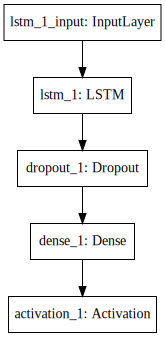

In [4]:
n_hidden = 80     # 出力次元
epochs = 100      # エポック数
batch_size = 10   # ミニバッチサイズ

# ネットワークモデル構築
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape = (None, maxlen, n_in),kernel_initializer = glorot_uniform(seed=1234), recurrent_initializer = orthogonal(gain=1.0, seed=1234), dropout = 0.5, recurrent_dropout = 0.5))
model.add(Dropout(0.5))
model.add(Dense(n_out,kernel_initializer = glorot_uniform(seed=1234)))
model.add(Activation("softmax"))
model.compile(loss="categorical_crossentropy", optimizer = "RMSprop", metrics = ['accuracy'])

# モデルのサマリを表示
model.summary()
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Train on 3346 samples, validate on 372 samples
Epoch 1/100
3346/3346 [==============================] - 21s - loss: 1.2394 - acc: 0.4041 - val_loss: 1.0241 - val_acc: 0.5753
Epoch 2/100
3346/3346 [==============================] - 19s - loss: 0.9879 - acc: 0.5580 - val_loss: 0.7234 - val_acc: 0.6962
Epoch 3/100
3346/3346 [==============================] - 19s - loss: 0.8265 - acc: 0.6342 - val_loss: 0.5556 - val_acc: 0.7984
Epoch 4/100
3346/3346 [==============================] - 19s - loss: 0.7551 - acc: 0.6635 - val_loss: 0.4819 - val_acc: 0.8548
Epoch 5/100
3346/3346 [==============================] - 20s - loss: 0.7024 - acc: 0.6922 - val_loss: 0.4258 - val_acc: 0.8763
Epoch 6/100
3346/3346 [==============================] - 19s - loss: 0.6606 - acc: 0.7149 - val_loss: 0.3940 - val_acc: 0.8575
Epoch 7/100
3346/3346 [==============================] - 19s - loss: 0.6451 - acc: 0.7218 - val_loss: 0.3874 - val_acc: 0.8441
Epoch 8/100
3346/3346 [==============================] - 19s - l

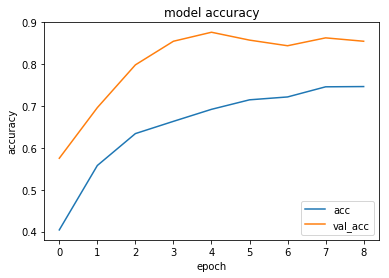

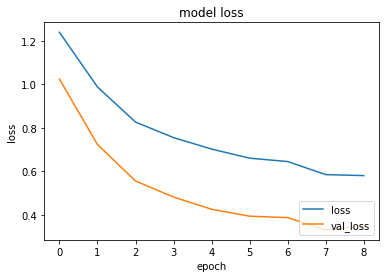

Wall time: 2min 59s


In [5]:
%%time

#データを学習用とテスト用に分割 
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, random_state=1234)         

# 学習
early_stopping = EarlyStopping(patience=0, verbose=1)
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1,shuffle = True, callbacks = [early_stopping], validation_split = 0.1)

# 精度の履歴をプロット
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc', 'val_acc'], loc='lower right')
plt.show()

# 損失の履歴をプロット
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show()

In [6]:
# テスト
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("score:", score)

#識別率（騰落４分類）
y_pred = model.predict(x_test)
correct = 0
semi_correct = 0
for i in range(len(y_pred)):
  pred = np.argmax(y_pred[i,:])
  tar = np.argmax(y_test[i,:])
  if pred == tar :
    correct += 1
  else :
    if pred+tar == 1 or pred+tar == 5 :
      semi_correct += 1

print("識別率（騰落４分類）: %6.5f" % (1.0 * correct / len(y_pred)))
print("識別率（騰落）: %6.5f" % (1.0 * (correct+semi_correct) / len(y_pred)))

380/414 [==========================>...] - ETA: 0sscore: [0.3204178553128588, 0.8792270430620166]
識別率（騰落４分類）: 0.87923
識別率（騰落）: 0.97585
